## Motivation:

A common use-case in any organization whether it be employee attribute or customer retention. 



## Goals:


Predict 

In [2]:
!pip install seaborn --upgrade

Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/bank-churn"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [23]:
start_time = time.time()

In [5]:
# Load Data

data = pd.read_csv('churn.csv')

In [6]:
# 10000 bank customers
data.shape

(10000, 14)

In [7]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis

In [8]:
data.groupby('Geography')['CustomerId'].count()

Geography
France     5014
Germany    2509
Spain      2477
Name: CustomerId, dtype: int64

From the plots, they are mostly gaussian distribution. That's good, so we don't need to do some transformations.

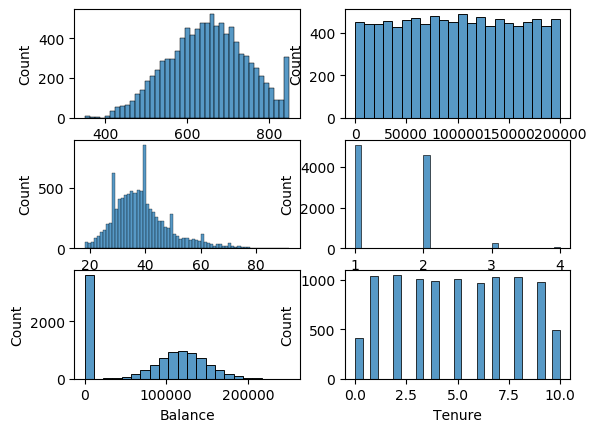

In [9]:

fig, axes = plt.subplots(3,2) 
sns.histplot(ax = axes[0][0], x=data.CreditScore)
sns.histplot(ax = axes[1][0], x=data.Age)
sns.histplot(ax = axes[2][0], x=data.Balance)

sns.histplot(ax = axes[0][1], x=data.EstimatedSalary)
sns.histplot(ax = axes[1][1], x=data.NumOfProducts)
sns.histplot(ax = axes[2][1], x=data.Tenure)
plt.show()

## Feature Engineering

It is not enough to provide label encoding to these categorical features. For example, if we convert Geography from x,y, and z to 0,1,2... it implies there is ordering which introduce bias in the model. Therefore, need to utilize onehot encoding.

In [10]:
## Perform One Hot Encoding for Geography and Gender

data = pd.concat([data,pd.get_dummies(data.Geography, prefix='Country')], axis = 1)
data.drop(['Geography'], axis = 1, inplace = True)

data = pd.concat([data,pd.get_dummies(data.Gender, prefix='Gender')], axis = 1)
data.drop(['Gender'], axis = 1, inplace = True)


In [11]:
# Remove RowNumber, CustomerId, and Surname based on knowledge/domain experience.
data.drop(['RowNumber','CustomerId','Surname'], axis = 1, inplace = True)

In [12]:
# Reformatting so it can be accepted in xgboost.
#Note: For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.
# See: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

features = ['CreditScore',	'Age',	'Tenure',	'Balance',	'NumOfProducts',	'HasCrCard',	'IsActiveMember',	'EstimatedSalary',		'Country_France',	'Country_Germany',	'Country_Spain',	'Country_France',	'Country_Germany',	'Country_Spain',	'Gender_Female',	'Gender_Male']

data = pd.concat((data['Exited'], data[features]), axis = 1)

In [13]:
data

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Country_France,Country_Germany,Country_Spain,Country_France,Country_Germany,Country_Spain,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,1,0
1,0,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0,1,1,0
2,1,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,1,0
3,0,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0,0,1,0
4,0,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,771,39,5,0.00,2,1,0,96270.64,1,0,0,1,0,0,0,1
9996,0,516,35,10,57369.61,1,1,1,101699.77,1,0,0,1,0,0,0,1
9997,1,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,0,0,1,0
9998,1,772,42,3,75075.31,2,1,0,92888.52,0,1,0,0,1,0,0,1


## Split to Train, Validation, and Test Set

In [14]:
# code borrowed from sagemaker notebook: xgboost_customer_churn.ipynb
train_data, validation_data, test_data = np.split(
    data.sample(frac=1, random_state=1729),
    [int(0.7 * len(data)), int(0.9 * len(data))],
)

train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

In [15]:
# Upload data to our bucket.

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

Note: Typically, we would perform scaling after data is split. We don't want to leak out information to the test set when performing the scaling. It is supposed to be unseen data. Howerver, for Decision Tree and Ensemble Techniques like XGBoost

See: https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31#:~:text=Important%20Points%20to%20Remember%3A,data%20into%20training%20and%20testing

## Train the Model

In [17]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

In [18]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [25]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    eval_metric="auc",
    max_depth=5,
    objective="binary:logistic",
    num_round=10,
)



In [26]:
from sagemaker.tuner import (
    ContinuousParameter,
    HyperparameterTuner,
)

# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# Setting up Hyperparamters and job

objective_metric_name = "validation:auc"


hyperparameter_ranges = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "gamma": ContinuousParameter(0.01, 10, scaling_type="Logarithmic")
}


In [27]:
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
)

# Train the Model
tuner_log.fit({"train": s3_input_train, "validation": s3_input_validation})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................!


## Make the Endpoint

In [28]:

xgb_predictor = tuner_log.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)


2022-12-04 19:59:57 Starting - Preparing the instances for training
2022-12-04 19:59:57 Downloading - Downloading input data
2022-12-04 19:59:57 Training - Training image download completed. Training in progress.
2022-12-04 19:59:57 Uploading - Uploading generated training model
2022-12-04 19:59:57 Completed - Resource retained for reuse
-------!

## Make Inferences

For CSV inference, the algorithm assumes that CSV input does not have the label column.
See: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

In [29]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]


predictions = predict(test_data.to_numpy()[:, 1:])

In [30]:
predictions = np.array([float(num) for num in predictions])
print(predictions)

[0.04751325 0.07079252 0.04532289 0.10755198 0.24770755 0.04366031
 0.51697034 0.0562619  0.11353371 0.92949408 0.27352089 0.67257702
 0.08485536 0.1277363  0.18645319 0.67395329 0.19991206 0.03821642
 0.04900043 0.16270427 0.19765382 0.16772442 0.11363258 0.03821642
 0.18645319 0.93869632 0.19108482 0.36235419 0.03798985 0.14398846
 0.70625848 0.11363258 0.4027068  0.13515076 0.16418144 0.23648231
 0.0464488  0.35673702 0.18171403 0.03732501 0.1338391  0.04346482
 0.77420807 0.71473205 0.08485536 0.59337813 0.11855917 0.09604938
 0.08724353 0.06523094 0.08481106 0.35579419 0.05509522 0.1277363
 0.07061758 0.12936921 0.10059627 0.06110755 0.34429178 0.0562619
 0.40794638 0.17532206 0.43964538 0.36235419 0.72185832 0.6223402
 0.15299229 0.25845879 0.31940088 0.09604938 0.291042   0.10439139
 0.07317394 0.82749909 0.10262727 0.20399669 0.23645574 0.27223954
 0.07518623 0.16341145 0.04053403 0.06416917 0.90563792 0.14241204
 0.20738205 0.94421858 0.07410982 0.1440759  0.03903994 0.9358805

## Evaluation
Compare against Dummy Classifier. This is to see if our model is useful or is not better than guessing.

In [31]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(test_data.iloc[:,1:], test_data['Exited'])

dummy_clf.predict(test_data.iloc[:,1:])
dummy_clf.score(test_data.iloc[:,1:], test_data['Exited'])

0.663

In [32]:
# Confusion Matrix

pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

# Accuracy is 84.9%

predictions,0.0,1.0
actual,,
0,755,26
1,125,94


In [33]:
end_time = time.time()
print(end_time - start_time)

713.0360727310181


## Delete the Endpoint
When we're done making inferences

In [35]:
sess.delete_endpoint(endpoint_name=xgb_predictor.endpoint_name)


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:258532878709:endpoint/sagemaker-xgboost-221204-1955-004-7e84e614".

# Looking Ahead

1. Train with protobuf format and compare time between csv format.
2. Add DescribeTrainingJob into the notebook
3. Perform HyperparameterTuning

## Resources:

1. https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.html
2. https://github.com/Kaggle/kaggle-api
   - to download files from kaggle
3. https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
   - subplots for seaborn
4. https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
   - one-hot encoding implementation
5. https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
   - SageMaker Documentation for XGBoost
6. https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31#:~:text=Important%20Points%20to%20Remember%3A,data%20into%20training%20and%20testing
   - why you don't to scale data for xgboost
7. https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/xgboost_random_log/hpo_xgboost_random_log.ipynb
   - Hyperparameter tuning